# 2024 1학기 기계학습 심화 팀 프로젝트
## Pidray dataset을 이용한 Image Classification Using CNN
## B911166 전민

train data로는 29457장의 이미지를 사용하여 학습하였고 test data로는 9482장의 이미지를 사용하였다.
test data로는 각각 Hard, Easy, Hidden image set이 존재했고 그 중 금지 품목이 한 개만 포함된 Easy set을 사용하여 모델 테스트를 진행하였다.
https://github.com/bywang2018/security-dataset/blob/main/README.md


In [190]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [191]:
import os
import torch
import torch.nn as nn
import torch.optim as optim

In [192]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

root = './'

Using cpu device


In [193]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [194]:
# load image
img =  cv2.imread('./pidray/train/images/xray_00000.png') # Reads an image into BGR Format

img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)   #load image with RGB format
img_size = img.shape
print(img_size)

(448, 620, 3)


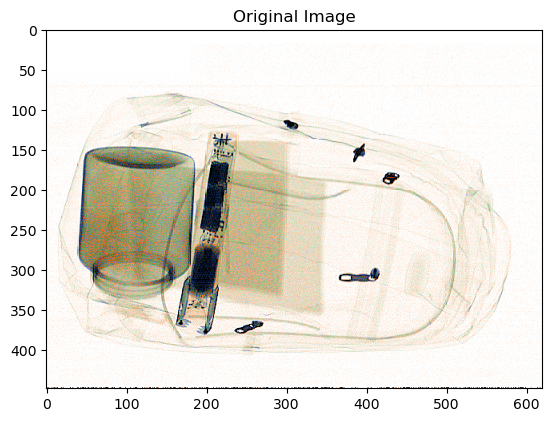

In [195]:
# Display original image
plt.imshow(img)
plt.title("Original Image")
plt.show()

In [196]:
all_pixels  = img.reshape((-1,3)).astype(float) # all_pixels : data
print(all_pixels.shape)

(277760, 3)


In [197]:
from torch.utils.data import Dataset
from PIL import Image

In [198]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, img_dir, annotation_dir, transform=None):
        self.img_dir = img_dir
        self.annotation_dir = annotation_dir
        self.transform = transform
        self.img_names = os.listdir(img_dir)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        annotation_path = os.path.join(self.annotation_dir, self.img_names[idx].replace('.png', '.txt'))

        image = Image.open(img_path).convert("RGB")
        
        with open(annotation_path, 'r') as f:
            bbox_data = f.readline().strip().split()
            label = int(bbox_data[0])
            bbox = torch.tensor([float(b) for b in bbox_data[1:]])
            
        if self.transform:
            image = self.transform(image)
        
        return image, label, bbox


In [199]:
import torchvision
import torchvision.transforms as transforms

In [200]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # 노말리이징: (원래 데이터 x - μ) / σ   μ=(0.5,0.5,0.5) σ = (0.5, 0.5, 0.5). 값이 세개인 이유는 RGB라서 채널이 세개이기 떄문
    transforms.Resize((480,600)) # 모든 이미지를 480 x 600의 사이즈로 리사이징
])

train_image_dir = './Pidray/train/images'
train_label_dir = './Pidray/train/labels'
test_image_dir = './Pidray/test/images'
test_label_dir = './Pidray/test/labels'

train_data = CustomDataset(train_image_dir, train_label_dir, transform=trans)
test_data = CustomDataset(test_image_dir, test_label_dir, transform=trans)

print('Training Data:', len(train_data), 'Test Data', len(test_data))


batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=False)

Training Data: 29457 Test Data 9482


In [201]:
classes = ["Baton", "Pliers", "Hammer", "Powerbank", 
        "Scissors", "Wrench", "Gun", "Bullet", 
        "Sprayer", "Handcuffs", "Knife", "lighter"]

In [202]:
import matplotlib.patches as patches

# 바운딩 박스를 그리는 함수
def draw_bbox(ax, bbox, label):
    # bbox = [x_center, y_center, width, height]
    # 이미지 크기에 따라 실제 바운딩 박스의 좌표로 변환
    x_center, y_center, width, height = bbox
    x1 = (x_center - width / 2) * 600   # 이미지 너비에 맞춰 조정
    y1 = (y_center - height / 2) * 480  # 이미지 높이에 맞춰 조정
    
    # 바운딩 박스 그리기
    rect = patches.Rectangle((x1, y1), width * 600, height * 480, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    # 라벨 표시
    ax.text(x1, y1, label, color='white', backgroundcolor='red')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


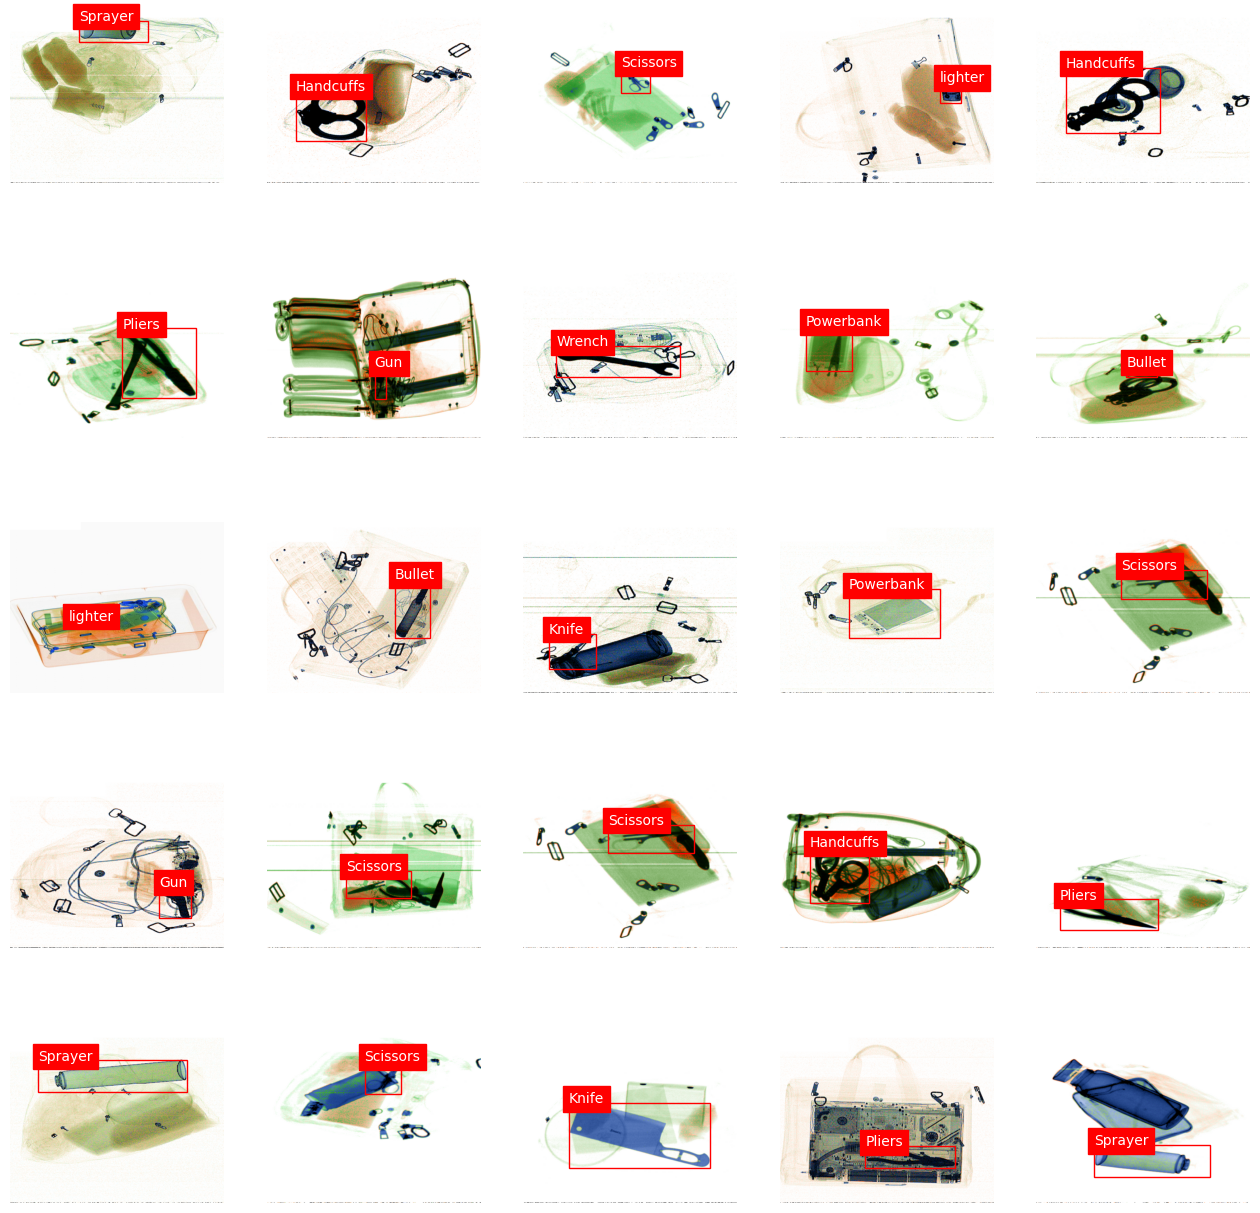

In [203]:
# 데이터 로더에서 첫 번째 배치만 가져오기
images, labels, bboxes = next(iter(train_loader))

# batch size: 64, kernel: 3(RGB), image size: 480 x 600
sample_index = np.random.choice(batch_size, size=25)     # 25개의 랜덤 샘플 인덱스 선택
num_samples = sample_index.size

random_samples = images[sample_index].cpu().numpy()

plt.figure(figsize=(16, 16))

# 테스트 샘플 표시
for k in range(num_samples):
    ax = plt.subplot(5, 5, k + 1)
    img = random_samples[k].reshape(3,480, 600).transpose(1,2,0)/2 + 0.5
    plt.imshow(img)
    label = classes[labels[sample_index[k]].item()]
    bbox = bboxes[sample_index[k]] # 해당 샘플의 바운딩 박스 정보
    draw_bbox(ax, bbox, label) # 바운딩 박스 그리기
    plt.axis('off')

plt.show() 

In [204]:
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 5),   # RGB 이미지를 위해 입력 채널을 3으로 설정
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(117*147*64, 512),  # 이미지 크기와 출력 채널을 반영하여 입력 크기 조정
            nn.ReLU(),  # 학습을 개선하기 위해 활성화 함수 추가
            nn.Linear(512, 12)  # 클래스가 총 12개이므로 마지막 채널 수를 12로 조정
        )

    def forward(self, x):
        logits = self.conv_layers(x)
        return(logits)
    
model = MyConvNet().to(device)
print(model)

MyConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1100736, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=12, bias=True)
  )
)


In [205]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss()

In [207]:
# training and test

# epoch: 10
# data dimension: batch_size x Channels x Height x Width (NCHW)
for epoch in range(10):
    # training phase
    # model.train()  # drop out layer가 있다면 drop out을 활성화. 지금은 없어서 상관 없음
    current_loss= 0.0
    for batch_num, (x, target, bbox) in enumerate(train_loader):
        x, target = x.to(device), target.to(device)

        # forward propagation
        out = model(x)
        loss = criterion(out,target)

        # backward propagation
        optimizer.zero_grad()   # 미분값 리셋
        loss.backward()
        optimizer.step()
        current_loss += loss

        # display the training loss in every 100 batches
        if (batch_num+1)%100 == 0 or (batch_num+1)%100 == len(train_loader):
            print('epoch: %d, batch_num: %d, current_loss: %.3f' %(epoch, batch_num+1, current_loss/100))
            current_loss = 0.0


    # test phase
    with torch.no_grad():
        # model.eval()        # test시에는 drop out을 적용하면 안됨. 만일 drop out이 켜져있다면 eval()로 모든 레이어를 활성화할 수 있다.
        total_samples = 0.0
        correct_samples = 0.0
        for (x, target, bbox) in test_loader:
            x, target = x.to(device), target.to(device)
            out = model(x)
            pred = torch.argmax(out,1)
            correct_samples += (pred == target).sum()
        print('Accuracy: %.3f' %(100*float(correct_samples) / float(len(test_data))))

